# Simple Deep Learning mit AWS SageMaker

In dieser kurzen Hands-On-Demo entwickeln wir einen Image Classifier für ein eigenes Dataset.
Wir verwenden ein vortrainiertes neuronales Netz und mittels Transfer Learning und Fine Tuning wollen 2 Klassen trainieren, die das Netz vorher noch nicht kannte.

Als Dataset verwenden wir die codecentric Team-Fotos unserer Kollegen. Diese haben wir in einem S3 Bucket als ZIP File abgelegt.

Die Bilder sehen in etwa so aus:

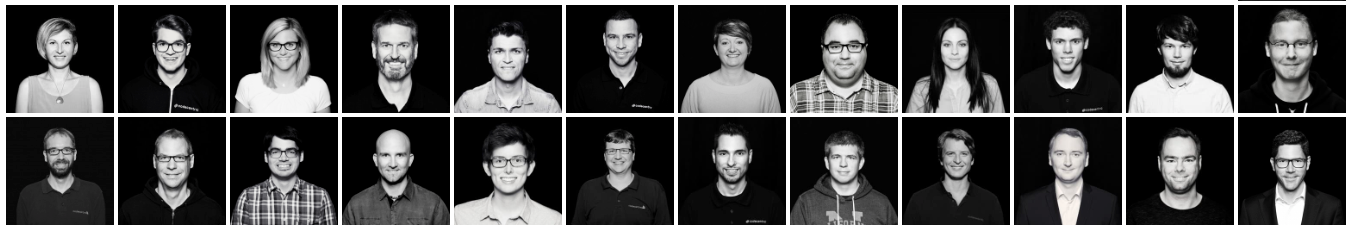

Das Set enthält 460 Bilder und der Classifier soll lernen, ob die Person eine Brille trägt oder nicht.

Diese Demo orientiert sich an den Beispiel Notebooks von AWS SageMaker (genauer: Image-classification-lst-format.ipynb).

Als erstes initialisieren wir unsere Umgebung und setzen ein paar Parameter. Wir brauchen eine Execution Role, um Services berechtigen zu können und müssen einen Docker Container für die Trainingsumgebung angeben. Ausserdem müssen wir wissen in welchem S3 Bucket unsere Daten liegen:

In [ ]:
%%time
%matplotlib inline

import matplotlib.pyplot as plt
import cv2
import boto3
import random
import os
import time
from time import gmtime, strftime
from sagemaker import get_execution_role
import json
import numpy as np

role = get_execution_role()

bucket='sagemakerbucket' # customize to your bucket
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/image-classification:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/image-classification:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/image-classification:latest'}
training_image = containers[boto3.Session().region_name]

## Daten aus S3 in die Notebook Umgebung laden und auspacken

Mit einem ! kann man ganz einfach Shell Befehle ausführen. Diese werden dann im Context des Jupyter Notebook Containers ausgeführt.

In [ ]:
!aws s3 cp s3://$bucket/glasses.zip glasses.zip

In [ ]:
!rm -rf data
!mkdir data
!mv glasses.zip data/
!cd data && unzip glasses.zip 

Erzeuge eine Liste von allen Bildern:

In [ ]:
ALL_IMAGES = !find data/*glasses/ -type f
print(len(ALL_IMAGES))

Die Bilder anonymisieren (anstatt der Namen von den Kollegen nummerieren wir die Bilder einfach durch):

In [ ]:
for i, img in enumerate(ALL_IMAGES):
    _path = img.split("/")
    _extension = _path[-1].split(".")[-1]
    new_filename = "{}/{}/{}.{}".format(_path[0], _path[1], "image_{}".format(i), _extension)
    os.rename(img, new_filename)


Die Bilder in ein einheitliches Format bringen (pngs nach jpg konvertieren etc):

In [ ]:
# convert all images to jpg

ALL_IMAGES = !find data/*glasses/ -type f

for i, img in enumerate(ALL_IMAGES):
    _path = img.split("/")
    _index = _path[-1].split(".")[0].split("_")[1]
    _extension = _path[-1].split(".")[-1]
    new_filename = "{}/{}/{}.{}".format(_path[0], _path[1], "image_{}".format(_index), "jpg")

    img_data = cv2.imread(img)
    os.remove(img)
    cv2.imwrite(new_filename, img_data)
    print("saving image {} to {}".format(img, new_filename))

Gibt es Bilder mit Size 0? Wenn ja, löschen (das führt sonst zu Problemen im Trainingsprozess):

In [ ]:
empty_file = !find data -size 0
empty_file = empty_file[0]
!rm $empty_file

Erzeuge Liste von allen Bildern mit Brille und allen Bildern ohne Brille:

In [ ]:
GLASSES = !find data/glasses/ -type f
print("Bilder mit Brille: ", len(GLASSES))

In [ ]:
NO_GLASSES = !find data/no_glasses/ -type f
print("Bilder ohne Brille: ", len(NO_GLASSES))

## Mal ein Paar Bilder visualisieren

In [ ]:
def plot_images(sample_images):
    plt.figure(figsize=(20,20))

    columns = 5
    for i, image_name in enumerate(sample_images):
        plt.subplot(len(sample_images) / columns + 1, columns, i + 1)
        plt.axis('off')
        image = cv2.imread(image_name)
        plt.imshow(image)

In [ ]:
plot_images(GLASSES[:5])

In [ ]:
plot_images(NO_GLASSES[:5])

## random Split Train und Validation Data

* Wir verwenden 90% der Bilder als Trainingsdaten und 10% zur Validierung.
* Dazu erzeugen wir einfach 2 getrennte Listen mit Dateinamen.

In [ ]:
IMAGES = !find data/*glasses/ -type f

In [ ]:
num_images = len(IMAGES)
# split 90% for train and 10% for validation
num_train = int(num_images * 0.9)

random.shuffle(IMAGES)

train_data = IMAGES[:num_train]
val_data = IMAGES[num_train:]

### create .lst files for training and validation

Der SageMaker Algorithmus erwartet die Labels für die Daten in einem ".lst" Format. Dies ist ein einfaches Textfile, dass pro Zeil ein Bild mit den zugehörigen Labels enthält.

Ein .lst file sieht zum Beispiel so aus (ohne den Header):

<pre>
<index>    <label>    <pfad>
123        1          ./bilder/bild1.jpg
124        3          ./bilder/bild2.jpg
</pre>

Die einzelnen Spalten sind durch TABs getrennt. Die Labels in diesem Fall sind kategorische Werte also zum Beispiel:

* 0 = Brille
* 1 = keine Brille

In [ ]:
label_map = {
    "glasses": 0, 
    "no_glasses": 1
    }

def write_lst_file(data, output_file):
    with open(output_file, "w") as f:
        for img in data:
            _, label, img_name = img.split("/")
            index = img_name.split(".")[0].split("_")[1]
            f.write("{index} \t {label} \t {relative_path}\n".format(index = index, 
                                                             label = label_map[label],
                                                             relative_path = img_name
                                                            ))

In [ ]:
write_lst_file(train_data, "train.lst")
write_lst_file(val_data, "val.lst")

In [ ]:
!tail -n3 val.lst
!cat val.lst |wc -l

### Upload to S3 for training

Die Daten für die Trainings-Instanz werden in S3 bereit gestellt. 

Wir kopieren hier einfach jedes File einzeln - <b>wenn man sehr viele Bilder hat, ist das keine gute Idee</b>. Zum einen dauert das sehr lange und zum anderen kann das auch teuer werden (man muss die "PUTs" nach S3 bezahlen).


In [ ]:
# Four channels: train, validation, train_lst, and validation_lst
s3_train = 's3://{}/train/'.format(bucket)
s3_val = 's3://{}/validation/'.format(bucket)
s3_train_lst = 's3://{}/train_lst/'.format(bucket)
s3_val_lst = 's3://{}/validation_lst/'.format(bucket)

# upload the image files to train and validation channels
for f in train_data:
    !aws s3 cp $f $s3_train 

for f in val_data:
    !aws s3 cp $f $s3_val 


In [ ]:
# upload the lst files to train_lst and validation_lst channels
!aws s3 cp train.lst $s3_train_lst 
!aws s3 cp val.lst $s3_val_lst 

## Trainings-Job konfigurieren

Die folgenden Parameter sind sogenannte Hyperparameter. Sie konfigurieren den Trainingsprozess.

In [ ]:
# The algorithm supports multiple network depth (number of layers). They are 18, 34, 50, 101, 152 and 200
# For this training, we will use 18 layers
num_layers = 18
# we need to specify the input image shape for the training data
image_shape = "3,224,224"
# we also need to specify the number of training samples in the training set
num_training_samples = len(train_data)
# specify the number of output classes
num_classes = 2
# batch size for training
mini_batch_size = 32
# number of epochs
epochs = 6
# learning rate
learning_rate = 0.01
# report top_5 accuracy
top_k = 5
# resize image before training
resize = 256
# period to store model parameters (in number of epochs), in this case, we will save parameters from epoch 2, 4, and 6
checkpoint_frequency = 2
# Since we are using transfer learning, we set use_pretrained_model to 1 so that weights can be 
# initialized with pre-trained weights
use_pretrained_model = 1

Jetzt erzeugen wir den Trainings-Job:

In [ ]:
%%time 

s3 = boto3.client('s3')
# create unique job name 
job_name_prefix = 'glasses-classifier'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = job_name_prefix + timestamp
training_params = \
{
    # specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket, job_name_prefix)
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_shape": image_shape,
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate),
        "top_k": str(top_k),
        "resize": str(resize),
        "checkpoint_frequency": str(checkpoint_frequency),
        "use_pretrained_model": str(use_pretrained_model)    
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },
#Training data should be inside a subdirectory called "train"
#Validation data should be inside a subdirectory called "validation"
#The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/train/'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/validation/'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",
            "CompressionType": "None"
        },
        {
            "ChannelName": "train_lst",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/train_lst/'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation_lst",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/validation_lst/'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",
            "CompressionType": "None"
        }
    ]
}
print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

Und schliesslich starten wir den Trainings-Job:

In [ ]:
# create the Amazon SageMaker training job
sagemaker = boto3.client(service_name='sagemaker')
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

## Create Model und Endpoint

Wenn das Training abgeschlossen ist, können wir ein Modell erzeugen. Dieses kann man dann deployen und über einen Endpoint ansprechen.

In [ ]:
%%time
import boto3
from time import gmtime, strftime

sage = boto3.Session().client(service_name='sagemaker') 

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
model_name="glasses-classifier-model" + timestamp
print(model_name)
info = sage.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)
hosting_image = containers[boto3.Session().region_name]
primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

Einen Endpoint für das Modell konfigurieren:

In [ ]:
from time import gmtime, strftime

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name_prefix + '-epc-' + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.p2.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

In [ ]:
%%time
import time

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name_prefix + '-ep-' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Jetzt den Endpoint starten:

In [ ]:
# get the status of the endpoint
response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))
    
try:
    sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)
finally:
    resp = sagemaker.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Arn: " + resp['EndpointArn'])
    print("Create endpoint ended with status: " + status)

    if status != 'InService':
        message = sagemaker.describe_endpoint(EndpointName=endpoint_name)['FailureReason']
        print('Training failed with the following error: {}'.format(message))
        raise Exception('Endpoint creation did not succeed')

## Show me what you learned

Jetzt schicken wir ein paar Bilder an den Endpoint, die das neuronale Netz während des Trainings nicht gesehen und schauen uns mal an, was der Classifier so vorhersagt. Dazu laden wir einfach ein paar Bilder aus dem Internet herunter ...



In [38]:
import boto3
runtime = boto3.Session().client(service_name='runtime.sagemaker') 

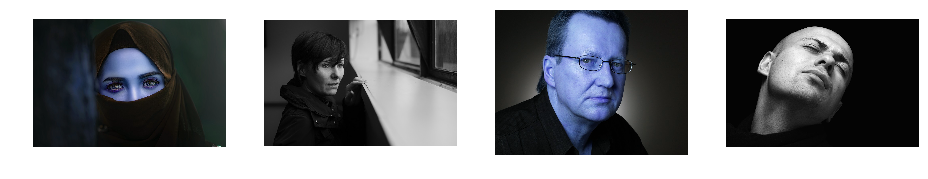

In [39]:
!rm -rf /tmp/test_images/
!mkdir /tmp/test_images/

!wget -O /tmp/test_images/test1.jpg https://cdn.pixabay.com/photo/2018/01/06/09/25/hijab-3064633_960_720.jpg --quiet
!wget -O /tmp/test_images/test2.jpg https://cdn.pixabay.com/photo/2015/03/04/20/25/sad-659422_960_720.jpg --quiet
!wget -O /tmp/test_images/test4.jpg https://cdn.pixabay.com/photo/2016/03/02/10/32/allrounder-1232059_960_720.jpg --quiet
!wget -O /tmp/test_images/test5.jpg https://cdn.pixabay.com/photo/2017/08/07/01/28/model-2598418_960_720.jpg --quiet

test_images = !find /tmp/test_images/* -type f

plot_images(test_images)

Jetzt schicken wir die Bilder an den Endpoint und schauen, wie die Prediction aussieht:

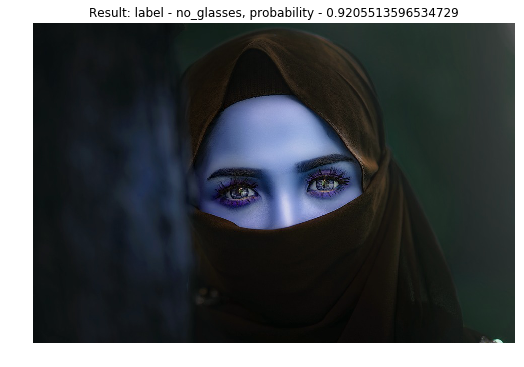

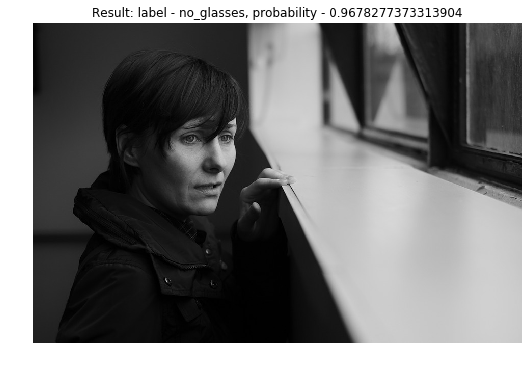

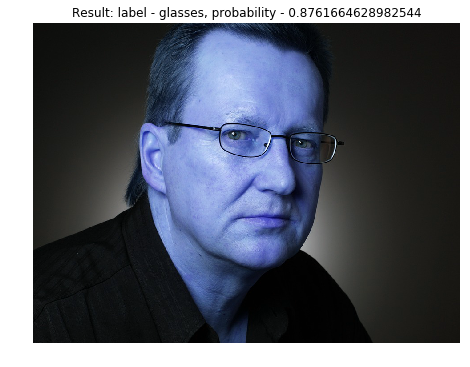

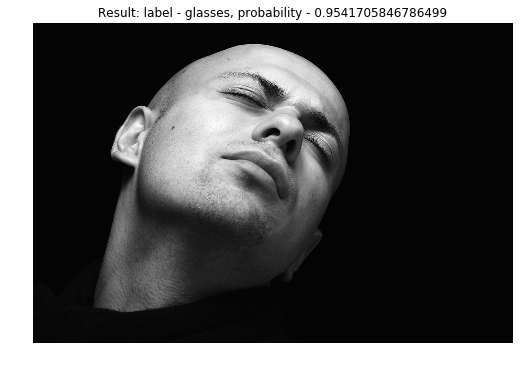

In [40]:
for i, test_image in enumerate(test_images):
    
    plt.figure(figsize=(20,20))
    columns = 2
    
    with open(test_image, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)
    response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                       ContentType='application/x-image', 
                                       Body=payload)
    result = response['Body'].read()
    # result will be in json format and convert it to ndarray
    result = json.loads(result)
    # the result will output the probabilities for all classes
    # find the class with maximum probability and print the class index
    index = np.argmax(result)
    object_categories = ['glasses', 'no_glasses']

    plt.subplot(len(test_images) / columns + 1, columns, i + 1)
    plt.axis('off')
    plt.title("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))
    image = cv2.imread(test_image)
    plt.imshow(image)

## Cleanup

Am Ende müssen wir noch "aufräumen". Das heisst <b>alle Ressourcen, die wir nicht mehr benötigen stoppen oder löschen. Ansonsten fallen dafür evtl. weitere Kosten an ...</b>

Dies gilt natürlich auch für das Notebook selbst, wir löschen hier nur den Endpoint:

In [ ]:
sage.delete_endpoint(EndpointName=endpoint_name)